AutoGluon

https://paperswithcode.com/paper/autogluon-timeseries-automl-for-probabilistic

https://auto.gluon.ai/dev/tutorials/timeseries/forecasting-quick-start.html

https://github.com/autogluon/autogluon

https://juejin.cn/post/7266889535341756476

In [ ]:
# We use uv for faster installation
!pip install uv
!uv pip install -q autogluon.timeseries --system
!uv pip uninstall -q torchaudio torchvision torchtext --system # fix incompatible package versions on Colab

In [ ]:
!uv pip install yfinance --system

Using Python 3.10.12 environment at: /usr
Audited 1 package in 73ms


In [ ]:
import yfinance as yf
import pandas as pd

# 設定台股 0050 的股票代號
ticker = '2330.TW'

# 下載歷史股價資料
data = yf.download(ticker, start='2023-01-01', end='2024-12-03')

# 重新命名欄位以便後續操作，移除空格
data.columns = ['Open', 'High', 'Low', 'Close', 'AdjClose', 'Volume']

# 計算成交金額 (amount) 並加入為新欄位
data['Amount'] = data['Volume'] * data['AdjClose']

# 設定 pandas 的全局顯示格式為小數點後四位
# pd.options.display.float_format = '{:.4f}'.format

# 新增一個名為 ticker 的欄位，填入對應的股票代號
data['ticker'] = ticker

# 將索引的日期轉換為 yyyymmdd 格式並重設索引
data.index = data.index.strftime('%Y-%m-%d')
data.index.name = 'Date'  # 設定索引名稱

# 將欄位移動到最前面
data = data.reset_index()
data = data[['Date', 'ticker', 'Open', 'High', 'Low', 'Close', 'AdjClose', 'Volume', 'Amount']]

# 顯示前五筆資料
print(data.head())

[*********************100%***********************]  1 of 1 completed

         Date   ticker        Open   High    Low  Close  AdjClose    Volume  \
0  2023-01-03  2330.TW  437.941528  453.0  453.5  443.0     446.0  14885824   
1  2023-01-04  2330.TW  434.557831  449.5  455.0  448.5     449.5  19188422   
2  2023-01-05  2330.TW  443.258728  458.5  459.5  455.0     459.0  23549581   
3  2023-01-06  2330.TW  443.258728  458.5  459.5  455.0     455.0  20886011   
4  2023-01-09  2330.TW  465.010773  481.0  481.0  467.5     468.0  46666263   

         Amount  
0  6.639078e+09  
1  8.625196e+09  
2  1.080926e+10  
3  9.503135e+09  
4  2.183981e+10  


In [ ]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [ ]:
def fill_stock_data_by_freq_d_yf(df):
    df_copy = df.copy()

    # 按天重新采樣資料
    df_copy['Date'] = pd.to_datetime(df_copy['Date'], format='%Y-%m-%d')
    df_copy = df_copy.set_index('Date').asfreq('D')

    # 填充缺失的資料
    df_copy['Open'] = df_copy['Open'].ffill()
    df_copy['High'] = df_copy['High'].fillna(df_copy['Open'])
    df_copy['Low'] = df_copy['Low'].fillna(df_copy['Open'])
    df_copy['Close'] = df_copy['Close'].fillna(df_copy['Open'])
    df_copy['AdjClose'] = df_copy['AdjClose'].fillna(df_copy['Close'])
    df_copy['Volume'] = df_copy['Volume'].fillna(0)
    df_copy['Amount'] = df_copy['Amount'].fillna(0)
    df_copy['ticker'] = df_copy['ticker'].fillna(ticker)

    # 重新轉回 yyyymmdd 格式
    df_copy.index = df_copy.index.strftime('%Y-%m-%d')
    df_copy.index.name = 'Date'

    # 重新檢查資料頻率
    print('資料頻率:', pd.infer_freq(pd.to_datetime(df_copy.index)))

    return df_copy.reset_index()

In [ ]:
# 填補資料並檢視
filled_data = fill_stock_data_by_freq_d_yf(data)
print(filled_data.head())

資料頻率: D
         Date   ticker        Open        High         Low       Close  \
0  2023-01-03  2330.TW  437.941528  453.000000  453.500000  443.000000   
1  2023-01-04  2330.TW  434.557831  449.500000  455.000000  448.500000   
2  2023-01-05  2330.TW  443.258728  458.500000  459.500000  455.000000   
3  2023-01-06  2330.TW  443.258728  458.500000  459.500000  455.000000   
4  2023-01-07  2330.TW  443.258728  443.258728  443.258728  443.258728   

     AdjClose      Volume        Amount  
0  446.000000  14885824.0  6.639078e+09  
1  449.500000  19188422.0  8.625196e+09  
2  459.000000  23549581.0  1.080926e+10  
3  455.000000  20886011.0  9.503135e+09  
4  443.258728         0.0  0.000000e+00  


In [ ]:
prediction_target = 'AdjClose'

,Date,ticker,Open,High,Low,Close,AdjClose,Volume,Amount
0,2023-01-03,2330.TW,437.941528,453.000000,453.500000,443.000000,446.000000,14885824.0,6.639078e+09
1,2023-01-04,2330.TW,434.557831,449.500000,455.000000,448.500000,449.500000,19188422.0,8.625196e+09
2,2023-01-05,2330.TW,443.258728,458.500000,459.500000,455.000000,459.000000,23549581.0,1.080926e+10
3,2023-01-06,2330.TW,443.258728,458.500000,459.500000,455.000000,455.000000,20886011.0,9.503135e+09
4,2023-01-07,2330.TW,443.258728,443.258728,443.258728,443.258728,443.258728,0.0,0.000000e+00


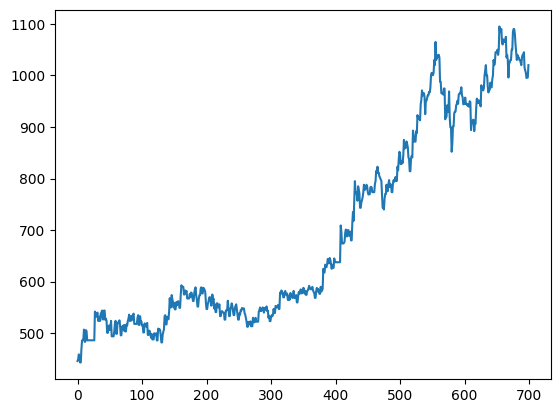

In [ ]:
filled_data[prediction_target].plot()
filled_data.head()

In [ ]:
# 將資料轉換為 TimeSeriesDataFrame 格式
data_ts = TimeSeriesDataFrame.from_data_frame(
    filled_data,
    id_column='ticker',
    timestamp_column='Date'
)

print('資料頻率:', data_ts.freq)

# 分割訓練和測試資料
train_data, test_data = data_ts.train_test_split(30)

print(f'訓練資料: 從 {train_data.index.tolist()[0][1]} 至 {train_data.index.tolist()[-1][1]}, 共計 {len(train_data)} 條')
print(f'測試資料: 從 {test_data.index.tolist()[0][1]} 至 {test_data.index.tolist()[-1][1]}, 共計 {len(test_data)} 條')

train_data.head()

資料頻率: D
訓練數據: 從 2023-01-03 00:00:00 至 2024-11-02 00:00:00, 共計 670 條
測試數據: 從 2023-01-03 00:00:00 至 2024-12-02 00:00:00, 共計 700 條


Open        High         Low       Close  \
item_id timestamp                                                    
2330.TW 2023-01-03  437.941528  453.000000  453.500000  443.000000   
        2023-01-04  434.557831  449.500000  455.000000  448.500000   
        2023-01-05  443.258728  458.500000  459.500000  455.000000   
        2023-01-06  443.258728  458.500000  459.500000  455.000000   
        2023-01-07  443.258728  443.258728  443.258728  443.258728   

                      AdjClose      Volume        Amount  
item_id timestamp                                         
2330.TW 2023-01-03  446.000000  14885824.0  6.639078e+09  
        2023-01-04  449.500000  19188422.0  8.625196e+09  
        2023-01-05  459.000000  23549581.0  1.080926e+10  
        2023-01-06  455.000000  20886011.0  9.503135e+09  
        2023-01-07  443.258728         0.0  0.000000e+00

In [ ]:
prediction_length = 30  # 預測範圍的長度

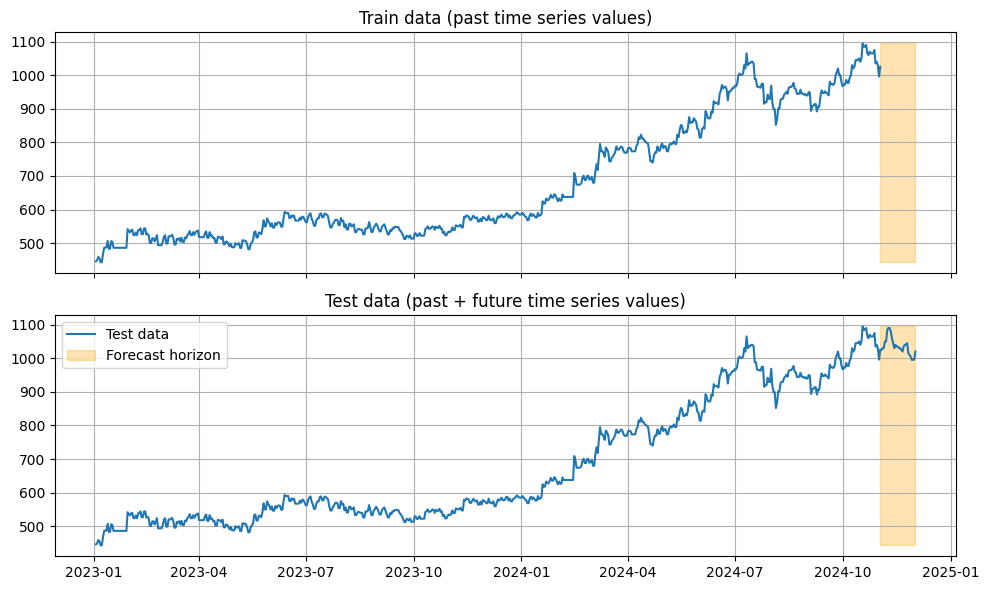

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 選取特定股票的訓練和測試資料
train_ts = train_data.loc[ticker][prediction_target]
test_ts = test_data.loc[ticker][prediction_target]

# 繪製圖表
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=[10, 6], sharex=True)

# 訓練資料圖表
ax1.set_title("Train data (past time series values)", fontsize=12)
ax1.plot(train_ts, label="Train data")
ax1.grid(True)

# 測試資料圖表
ax2.set_title("Test data (past + future time series values)", fontsize=12)
ax2.plot(test_ts, label="Test data")
ax2.grid(True)

# 添加預測區域陰影
for ax in (ax1, ax2):
    ax.fill_between(
        np.array([train_ts.index[-1], test_ts.index[-1]]),  # 陰影範圍
        test_ts.min(),  # 陰影的下界
        test_ts.max(),  # 陰影的上界
        color="orange", alpha=0.3, label="Forecast horizon"
    )

# 圖例和格式
ax2.legend(loc="upper left", fontsize=10)
plt.tight_layout()
plt.show()

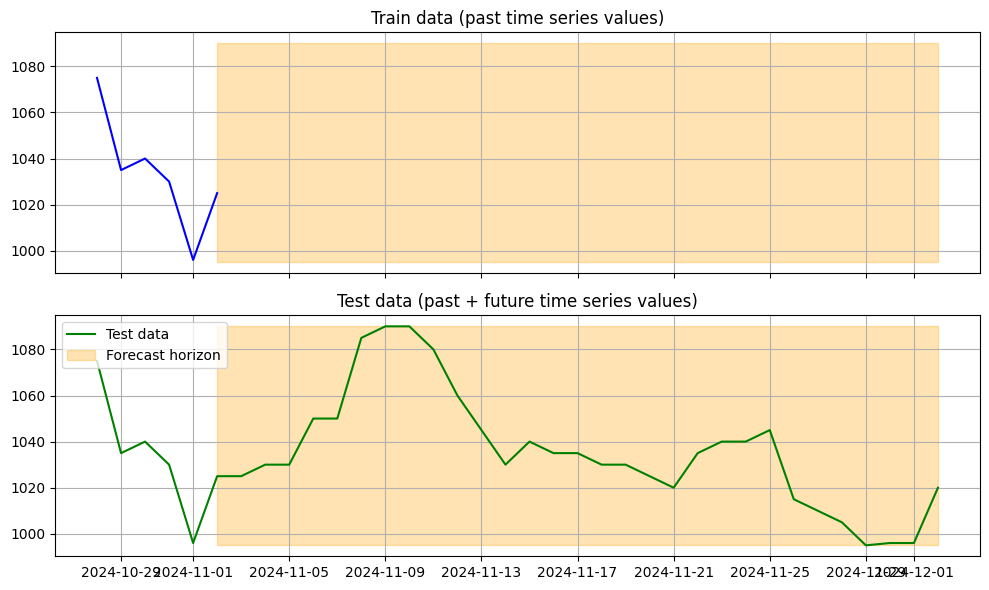

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 僅選取最近的資料進行繪製，限制為訓練資料的 1% 或更小範圍
limit = int(len(train_data) * 0.01)
train_ts = train_data.loc[ticker][prediction_target][-limit:]
test_ts = test_data.loc[ticker][prediction_target][-(limit + prediction_length):]

# 繪製圖表
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=[10, 6], sharex=True)

# 訓練資料
ax1.set_title("Train data (past time series values)", fontsize=12)
ax1.plot(train_ts, label="Train data", color="blue")
ax1.grid(True)

# 測試資料
ax2.set_title("Test data (past + future time series values)", fontsize=12)
ax2.plot(test_ts, label="Test data", color="green")
ax2.grid(True)

# 添加預測區域陰影
for ax in (ax1, ax2):
    ax.fill_between(
        np.array([train_ts.index[-1], test_ts.index[-1]]),
        test_ts.min(),
        test_ts.max(),
        color="orange",
        alpha=0.3,
        label="Forecast horizon",
    )

# 添加圖例與格式
ax2.legend(loc="upper left", fontsize=10)
plt.tight_layout()
plt.show()


In [ ]:
predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    path='autogluon-stock',
    target=prediction_target,
    eval_metric='MASE',
)

# 使用訓練資料訓練模型
predictor.fit(
    train_data,
    presets='best_quality',
    time_limit=60 * 20,
)

predictor.leaderboard(silent=True)

Beginning AutoGluon training... Time limit = 1200s
AutoGluon will save models to '/content/autogluon-stock'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.22 GB / 12.67 GB (80.6%)
Disk Space Avail:   73.02 GB / 107.72 GB (67.8%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 30,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'AdjClose',
 'time_limit': 1200,
 'verbosity': 2}

Inferred time series frequency: 'D'
Provided train_data has 670 rows, 1 

,model,score_val,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-1.222362,0.211833,1.833660,13
1,PatchTST,-1.318430,0.018834,168.610548,11
2,DeepAR,-1.418858,0.193000,192.168207,10
3,TiDE,-1.652031,0.029654,213.647651,12
4,ChronosFineTuned[bolt_small],-1.759164,0.109186,176.813981,8
5,ChronosZeroShot[bolt_base],-2.087362,3.703435,2.940700,7
6,RecursiveTabular,-2.211238,0.937803,3.956209,2
7,SeasonalNaive,-2.301387,0.018946,0.078655,1
8,TemporalFusionTransformer,-2.543930,0.043932,190.104081,9
9,DynamicOptimizedTheta,-2.655502,0.171300,0.393529,5


In [ ]:
# 使用訓練資料讓模型去預測出股票價格的未來資料
predictions = predictor.predict(train_data)

print(f'預測資料: 從 {predictions.index.tolist()[0][1]} 至 {predictions.index.tolist()[-1][1]}, 共計 {len(predictions)} 條')
predictions.head()

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


預測資料: 從 2024-11-03 00:00:00 至 2024-12-02 00:00:00, 共計 30 條


mean          0.1          0.2          0.3  \
item_id timestamp                                                        
2330.TW 2024-11-03  1050.336325  1014.864859  1028.340252  1036.863800   
        2024-11-04  1056.900268  1020.313588  1033.196237  1042.199011   
        2024-11-05  1062.801998  1023.986669  1036.986736  1047.422240   
        2024-11-06  1070.578947  1029.535405  1044.646911  1054.544178   
        2024-11-07  1071.824786  1028.993730  1044.271910  1054.836427   

                            0.4          0.5          0.6          0.7  \
item_id timestamp                                                        
2330.TW 2024-11-03  1044.416318  1050.336325  1057.331032  1063.880306   
        2024-11-04  1049.507235  1056.900268  1063.704777  1071.426368   
        2024-11-05  1055.727251  1062.801998  1070.158738  1078.094647   
        2024-11-06  1062.679726  1070.578947  1077.428968  1085.490569   
        2024-11-07  1063.739376  1071.824786  1079.854742  1088.142012   

                            0.8          0.9  
item_id timestamp                             
2330.TW 2024-11-03  1071.309515  1082.887961  
        2024-11-04  1080.288750  1093.454345  
        2024-11-05  1087.474458  1102.292259  
        2024-11-06  1095.066434  1109.718879  
        2024-11-07  1097.844212  1112.087892

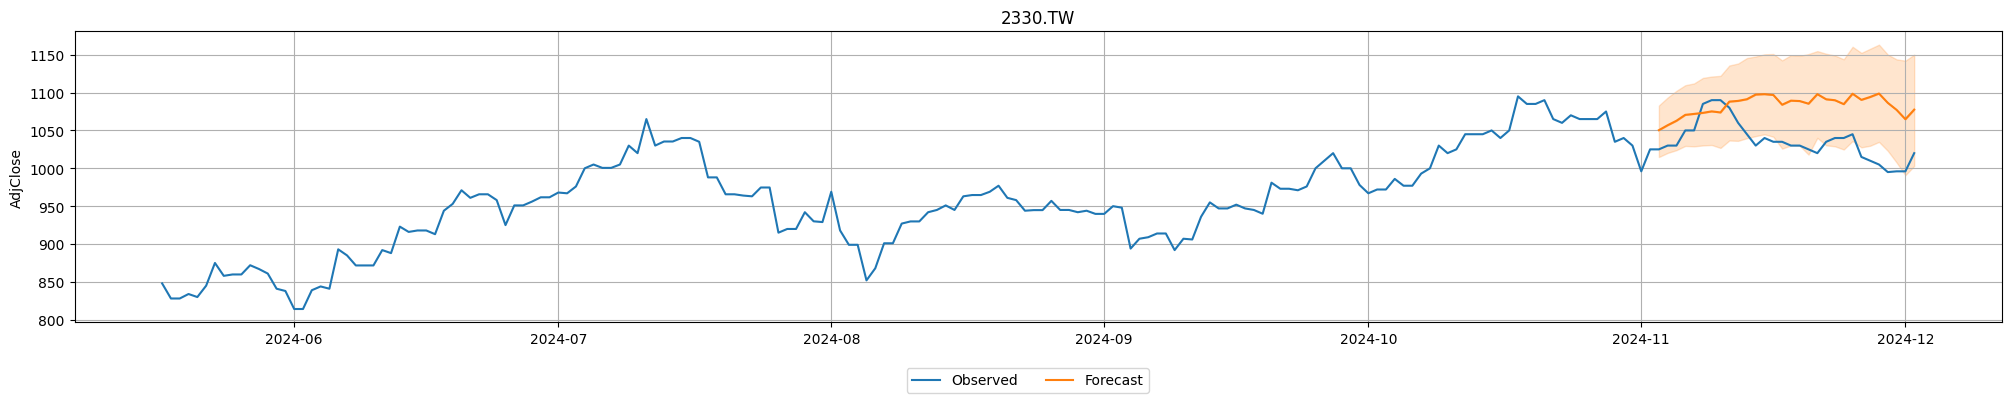

In [ ]:
predictor.plot(test_data, predictions, quantile_levels=[0.1, 0.9], max_history_length=200);

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


預測準確度分數 {'MASE': -2.4367340796968793}


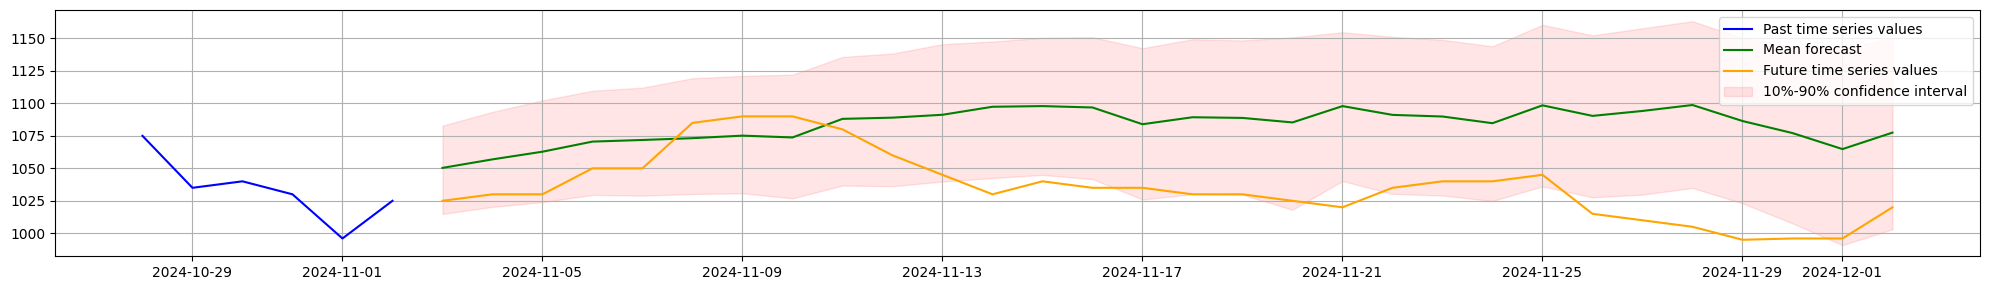

In [ ]:
import matplotlib.pyplot as plt

# 透過測試資料去評估預測的準確性
score = predictor.evaluate(test_data)
print('預測準確度分數', score)

# 訓練資料中的股票價格
y_past = train_data.loc[ticker][prediction_target]
# 預測資料中的股票價格
y_pred = predictions.loc[ticker]
# 測試資料中的股票價格(僅獲預測範圍內的資料)
y_test = test_data.loc[ticker][prediction_target][-prediction_length:]

plt.figure(figsize=(20, 3))

# 訓練資料僅展示 1% 的資料, 方便在圖形中直觀的查看預測的範圍
limit = int(len(y_past) * 0.01)
plt.plot(y_past[-limit:], label="Past time series values", color="blue")

# 預測資料 (平均值)
plt.plot(y_pred["mean"], label="Mean forecast", color="green")

# 測試資料 (實際值)
plt.plot(y_test, label="Future time series values", color="orange")

# 添加置信區間 (10%-90%)
plt.fill_between(
    y_pred.index,
    y_pred["0.1"],
    y_pred["0.9"],
    color="red",
    alpha=0.1,
    label="10%-90% confidence interval",
)

# plt.legend()
# plt.show()

# plt.title(f"Stock Forecast: {ticker}", fontsize=14)
# plt.xlabel("Date", fontsize=12)
# plt.ylabel(prediction_target, fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

在 AutoGluon 中，MASE（Mean Absolute Scaled Error）的計算結果顯示為負數，是因為 AutoGluon 將評估指標統一處理為 "higher-is-better" 的格式。如果原始指標是 "lower-is-better"（例如 MASE，因為數值越小代表模型的誤差越小），AutoGluon 會自動將結果乘以 -1 來翻轉其符號，這樣所有的指標都可以被解釋為「越高越好」。

這樣設計的目的是為了在模型比較時保持一致性，無論選擇哪種指標，都可以用相同的邏輯進行排序和比較。

In [ ]:
print('資料頻率:', data_ts.freq)

# 使用完整的資料作為訓練資料
train_data = data_ts

print(f'訓練資料: 從 {train_data.index.tolist()[0][1]} 至 {train_data.index.tolist()[-1][1]}, 共計 {len(train_data)} 條')

資料頻率: D
訓練資料: 從 2023-01-03 00:00:00 至 2024-12-02 00:00:00, 共計 700 條


Beginning AutoGluon training... Time limit = 1200s
AutoGluon will save models to '/content/autogluon-stock'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       9.84 GB / 12.67 GB (77.7%)
Disk Space Avail:   73.02 GB / 107.72 GB (67.8%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 30,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'AdjClose',
 'time_limit': 1200,
 'verbosity': 2}

Inferred time series frequency: 'D'
Provided train_data has 700 rows, 1 t

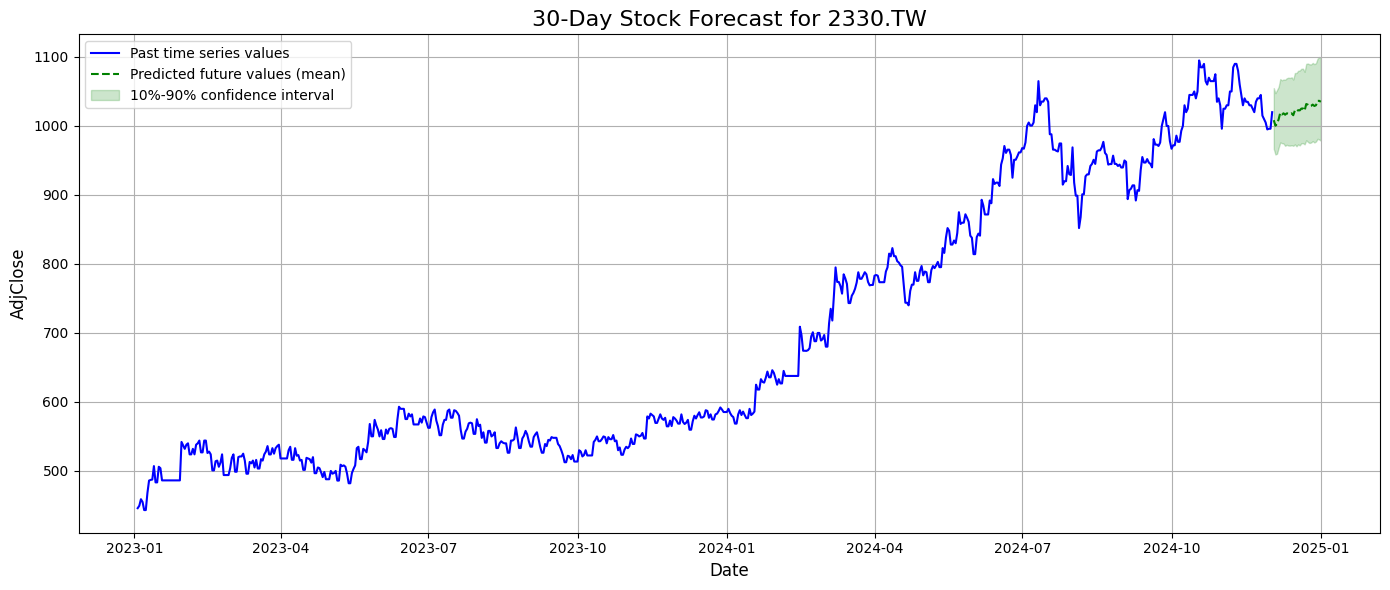

In [ ]:
from autogluon.timeseries import TimeSeriesPredictor
import matplotlib.pyplot as plt

# 設置參數
ts_code = "2330.TW"  # 替換為您的股票代號
prediction_target = "AdjClose"  # 預測目標
prediction_length = 30  # 預測未來天數

train_data = data_ts

# 訓練模型
predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    path='autogluon-stock',  # 模型保存路徑
    target=prediction_target,
    eval_metric='MASE'  # 評估指標
)
predictor.fit(
    train_data,
    presets='best_quality',
    time_limit=60 * 20,  # 訓練時間限制
)

# 預測未來 30 天
future_predictions = predictor.predict(train_data)

# 提取歷史數據
y_past = train_data.loc[ts_code][prediction_target]

# 提取預測結果
y_pred = future_predictions.loc[ts_code]

# 繪製圖表
plt.figure(figsize=(14, 6))

# 繪製歷史數據
plt.plot(y_past, label="Past time series values", color="blue", linewidth=1.5)

# 繪製預測均值
plt.plot(y_pred["mean"], label="Predicted future values (mean)", color="green", linestyle="--", linewidth=1.5)

# 繪製置信區間（10%-90%）
plt.fill_between(
    y_pred.index,
    y_pred["0.1"],
    y_pred["0.9"],
    color="green",
    alpha=0.2,
    label="10%-90% confidence interval"
)

# 添加圖例與標題
plt.title(f"30-Day Stock Forecast for {ts_code}", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel(prediction_target, fontsize=12)
plt.legend(loc="upper left", fontsize=10)
plt.grid(True)
plt.tight_layout()

# 顯示圖表
plt.show()
